# Setup

In [ ]:
# Install the textacy library for advanced NLP tasks
!pip install textacy
!pip install transformers datasets

In [54]:
print(textacy.__version__)

0.13.0


In [ ]:
!pip freeze > requirements.txt

In [ ]:
# imports
import kagglehub
import pandas as pd
import re
import html
import textacy.preprocessing as tprep
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Loading the dataset
path = kagglehub.dataset_download("tboyle10/medicaltranscriptions")

100%|██████████| 4.85M/4.85M [00:00<00:00, 43.9MB/s]

Extracting files...


In [ ]:
# Load the dataset from a CSV file and remove the unnecessary 'Unnamed: 0' column
df = pd.read_csv(path + '/mtsamples.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
...,...,...,...,...,...
4994,Patient having severe sinusitis about two to ...,Allergy / Immunology,Chronic Sinusitis,"HISTORY:, I had the pleasure of meeting and e...",NaN
4995,This is a 14-month-old baby boy Caucasian who...,Allergy / Immunology,Kawasaki Disease - Discharge Summary,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...","allergy / immunology, mucous membranes, conjun..."
4996,A female for a complete physical and follow u...,Allergy / Immunology,Followup on Asthma,"SUBJECTIVE: , This is a 42-year-old white fema...",NaN
4997,Mother states he has been wheezing and coughing.,Allergy / Immunology,Asthma in a 5-year-old,"CHIEF COMPLAINT: , This 5-year-old male presen...",NaN


# EDA

In [ ]:
# Count the occurrences of each unique value in the 'medical_specialty' column
df.value_counts('medical_specialty')

,count
medical_specialty,
Surgery,1103
Consult - History and Phy.,516
Cardiovascular / Pulmonary,372
Orthopedic,355
Radiology,273
General Medicine,259
Gastroenterology,230
Neurology,223
SOAP / Chart / Progress Notes,166


<ipython-input-7-083a6821e7c5>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', len(cause_dist))


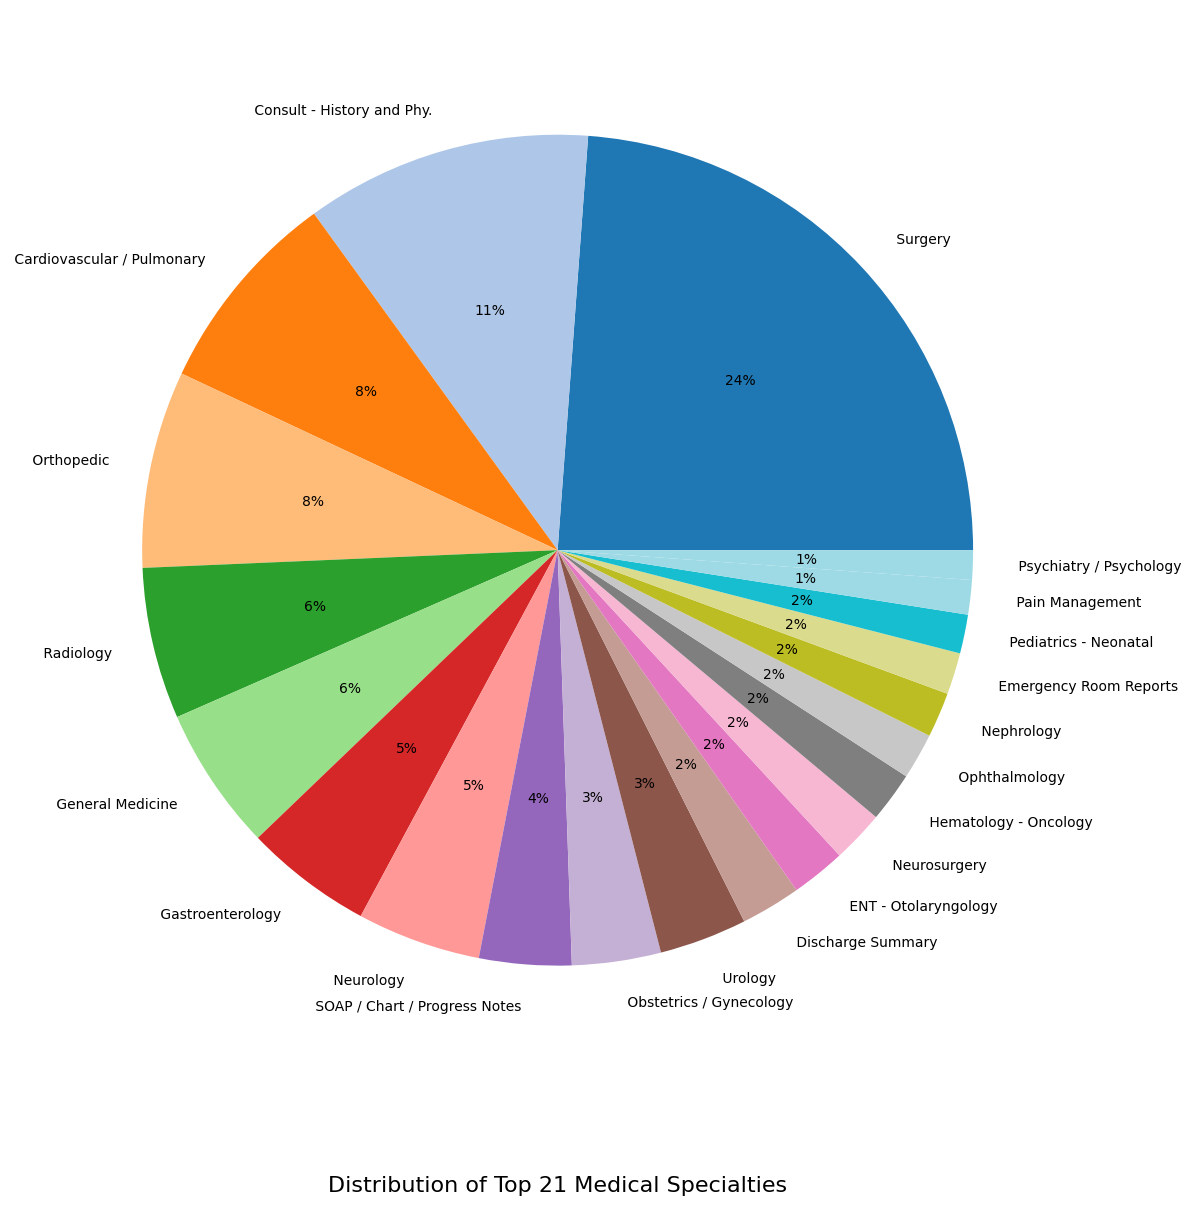

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Get the top 21 medical specialties and their counts
cause_dist = df['medical_specialty'].value_counts()[0:21]

# Generate a color palette using the 'tab20' colormap
colors = cm.get_cmap('tab20', len(cause_dist))

# Create a gradient color effect across the 'tab20' colormap
gradient_colors = [colors(i / len(cause_dist)) for i in range(len(cause_dist))]

# Create the pie chart
plt.figure(figsize=(12, 12))
plt.title('Distribution of Top 21 Medical Specialties', y=-0.1, fontsize=16)
plt.pie(cause_dist, labels=list(cause_dist.index), autopct="%.0f%%", colors=gradient_colors)
plt.axis('equal')  # Ensure pie chart is a perfect circle

# Display the chart
plt.tight_layout()
plt.show()


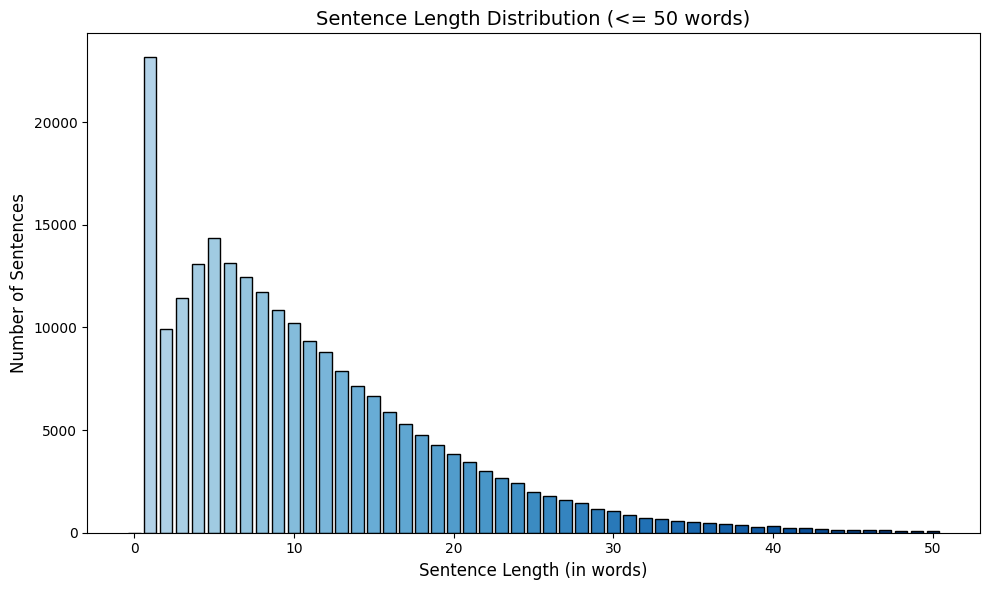

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm

# Ensure that we only process rows where 'transcription' is not null or NaN
df['sentence_lengths'] = df['transcription'].apply(lambda x: [len(sentence.split()) for sentence in str(x).split('.') if sentence] if pd.notnull(x) else [])

# Flattening the sentence lengths to a single list
all_sentence_lengths = [length for sublist in df['sentence_lengths'] for length in sublist]

# Filter sentence lengths to include only those <= 50
filtered_lengths = [length for length in all_sentence_lengths if length <= 50]

# Counting the frequency of each sentence length
length_counts = np.unique(filtered_lengths, return_counts=True)

# Unpacking lengths and their frequencies
sentence_lengths, frequency = length_counts

# Create a gradient blue color palette
colors = cm.Blues(np.linspace(0.3, 1, len(sentence_lengths)))  # Gradient from light to dark blue

# Plotting the data with gradient blue colors
plt.figure(figsize=(10, 6))
bars = plt.bar(sentence_lengths, frequency, color=colors, edgecolor='black')

# Adding labels and title
plt.xlabel('Sentence Length (in words)', fontsize=12)
plt.ylabel('Number of Sentences', fontsize=12)
plt.title('Sentence Length Distribution (<= 50 words)', fontsize=14)

# Adjusting layout and displaying the plot
plt.tight_layout()
plt.show()


In [ ]:
df['transcription'].apply(type).value_counts()

,count
transcription,
<class 'str'>,4966
<class 'float'>,33


<ipython-input-10-34f3f14cdbe5>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='medical_specialty', data=df, palette=colors)
<ipython-input-10-34f3f14cdbe5>:12: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.countplot(y='medical_specialty', data=df, palette=colors)


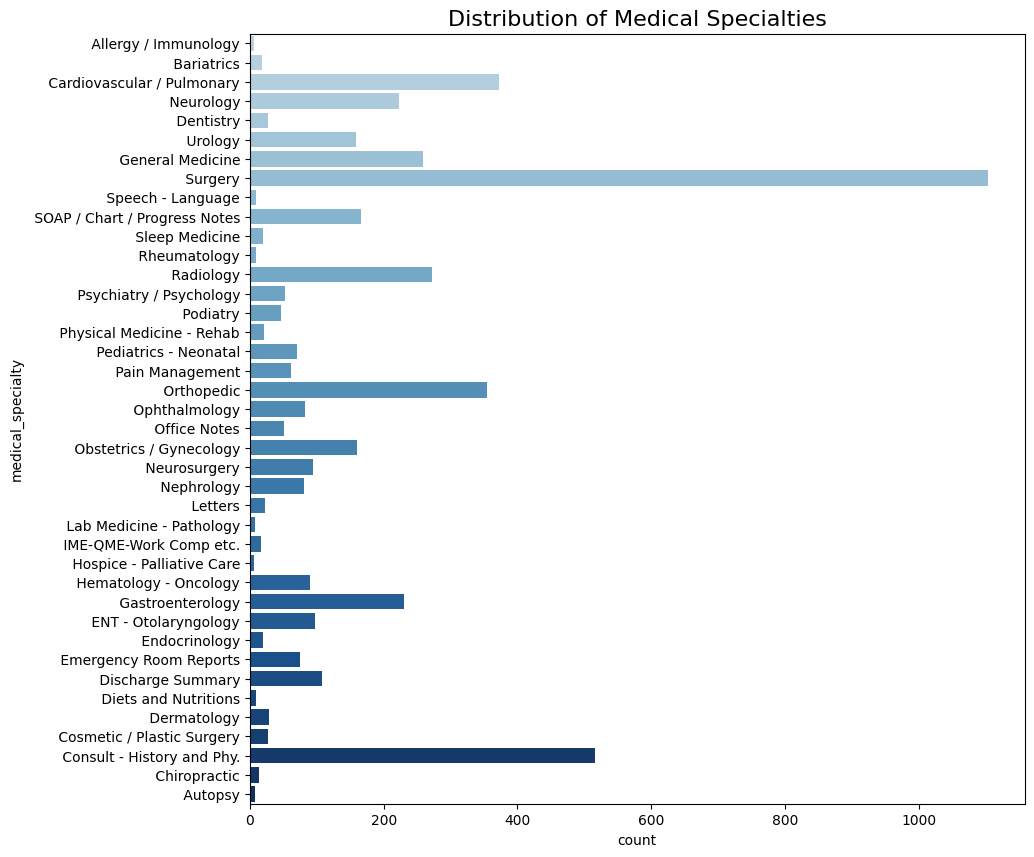

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Create a gradient blue color palette
num_categories = df['medical_specialty'].nunique()  # Get the number of unique specialties
colors = cm.Blues(np.linspace(0.3, 1, num_categories))  # Generate a range of blue colors

# Create the countplot with the gradient blue colors
plt.figure(figsize=(10, 10))
sns.countplot(y='medical_specialty', data=df, palette=colors)

# Display the plot
plt.title('Distribution of Medical Specialties', fontsize=16)
plt.show()


In [ ]:
# Standardize values in the 'medical_specialty' column by replacing specific terms and then count occurrences
df['medical_specialty'] = df['medical_specialty'].str.replace('Consult - History and Phy.', 'General Medicine')
df['medical_specialty'] = df['medical_specialty'].str.replace('Neurosurgery', 'Neurology')

df.value_counts('medical_specialty')

,count
medical_specialty,
Surgery,1103
General Medicine,775
Cardiovascular / Pulmonary,372
Orthopedic,355
Neurology,317
Radiology,273
Gastroenterology,230
SOAP / Chart / Progress Notes,166
Obstetrics / Gynecology,160


In [ ]:
# Filter the dataset to include only the top 6 most frequent medical specialties
top_categories = df['medical_specialty'].value_counts().head(6).index
df = df[df['medical_specialty'].isin(top_categories)]
df

,description,medical_specialty,sample_name,transcription,keywords,sentence_lengths
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple...","[4, 9, 2, 1, 6, 1, 11, 1, 4, 1, 3, 1, 12, 1, 6..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo...","[1, 10, 18, 5, 23, 19, 1, 6, 1, 8, 1, 5, 1, 16..."
7,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 3,"2-D ECHOCARDIOGRAM,Multiple views of the heart...","cardiovascular / pulmonary, 2-d echocardiogram...","[16, 4, 8, 8, 18, 7, 8, 5, 8, 5, 10, 12]"
9,Echocardiogram and Doppler,Cardiovascular / Pulmonary,2-D Echocardiogram - 4,"DESCRIPTION:,1. Normal cardiac chambers size....","cardiovascular / pulmonary, ejection fraction,...","[1, 4, 1, 4, 1, 4, 5, 1, 6, 1, 6, 1, 6, 1, 6, ..."
11,"Normal left ventricle, moderate biatrial enla...",Cardiovascular / Pulmonary,2-D Doppler,"2-D STUDY,1. Mild aortic stenosis, widely calc...","cardiovascular / pulmonary, 2-d study, doppler...","[2, 7, 1, 8, 1, 3, 1, 3, 1, 8, 1, 8, 1, 13, 1,..."
...,...,...,...,...,...,...
4972,Adenosine with nuclear scan as the patient un...,Cardiovascular / Pulmonary,Adenosine Nuclear Scan,"INDICATION: , Chest pain.,TYPE OF TEST: , Aden...","cardiovascular / pulmonary, adenosine nuclear ...","[4, 17, 10, 4, 2, 9, 4, 4, 1, 4, 1, 4, 10, 2, ..."
4973,Patient presents with a chief complaint of ch...,Cardiovascular / Pulmonary,Acute Inferior Myocardial Infarction,"CHIEF COMPLAINT: , Chest pain.,HISTORY OF PRES...",NaN,"[5, 20, 13, 17, 8, 18, 11, 8, 13, 6, 13, 16, 8..."
4974,Patient had a recurrent left arm pain after h...,Cardiovascular / Pulmonary,Angina - Consult,"HISTORY OF PRESENT ILLNESS: , The patient is a...",NaN,"[20, 33, 9, 30, 14, 14, 28, 21, 19, 48, 22, 21..."
4975,Patient had a markedly abnormal stress test w...,Cardiovascular / Pulmonary,Abnormal Stress Test,"HISTORY OF PRESENT ILLNESS: , Mr. ABC is a 60-...","cardiovascular / pulmonary, standard bruce, ni...","[6, 42, 17, 60, 55, 6, 12, 7, 7, 3, 6, 1, 24, ..."


In [ ]:
# Count the occurrences of each medical specialty in the filtered dataset
df.value_counts('medical_specialty')

,count
medical_specialty,
Surgery,1103
General Medicine,775
Cardiovascular / Pulmonary,372
Orthopedic,355
Neurology,317
Radiology,273


In [ ]:
# Remove rows where the 'transcription' column has missing values
df.dropna(subset=['transcription'], inplace=True)

<ipython-input-14-1290971e10fd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['transcription'], inplace=True)


In [ ]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt

# Load spaCy's English language model
nlp = spacy.load("en_core_web_sm")

# Define function to count nouns, verbs, and adjectives in text
def count_pos_tags(text):
    # Process the text using spaCy
    doc = nlp(text)

    # Initialize counters for nouns, verbs, and adjectives
    noun_count = 0
    verb_count = 0
    adj_count = 0

    # Iterate through tokens and count POS tags
    for token in doc:
        if token.pos_ == 'NOUN':
            noun_count += 1
        elif token.pos_ == 'VERB':
            verb_count += 1
        elif token.pos_ == 'ADJ':
            adj_count += 1

    return noun_count, verb_count, adj_count

# Function to split long transcriptions into chunks of manageable size
def split_text(text, chunk_size=50000):
    # Split the text into chunks of a specified size
    return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

# Apply the function to the 'transcription' column and get POS counts for each specialty
def process_specialty(specialty_transcriptions):
    # Join all transcriptions for a given specialty
    full_text = ' '.join(specialty_transcriptions)

    # Split the full text into smaller chunks
    chunks = split_text(full_text)

    # Count POS tags for each chunk and aggregate the results
    total_nouns, total_verbs, total_adjectives = 0, 0, 0
    for chunk in chunks:
        nouns, verbs, adjectives = count_pos_tags(chunk)
        total_nouns += nouns
        total_verbs += verbs
        total_adjectives += adjectives

    return total_nouns, total_verbs, total_adjectives

# Apply the function to get POS counts for each specialty
pos_counts = df.groupby('medical_specialty')['transcription'].apply(lambda x: process_specialty(x))

pos_df = pd.DataFrame(pos_counts.tolist(), columns=['Nouns', 'Verbs', 'Adjectives'], index=pos_counts.index)
pos_df

,Nouns,Verbs,Adjectives
medical_specialty,,,
Cardiovascular / Pulmonary,43712,17291,21911
General Medicine,108737,40475,45082
Neurology,41482,18422,18989
Orthopedic,51314,22684,23321
Radiology,20934,7298,11745
Surgery,136334,63266,60935


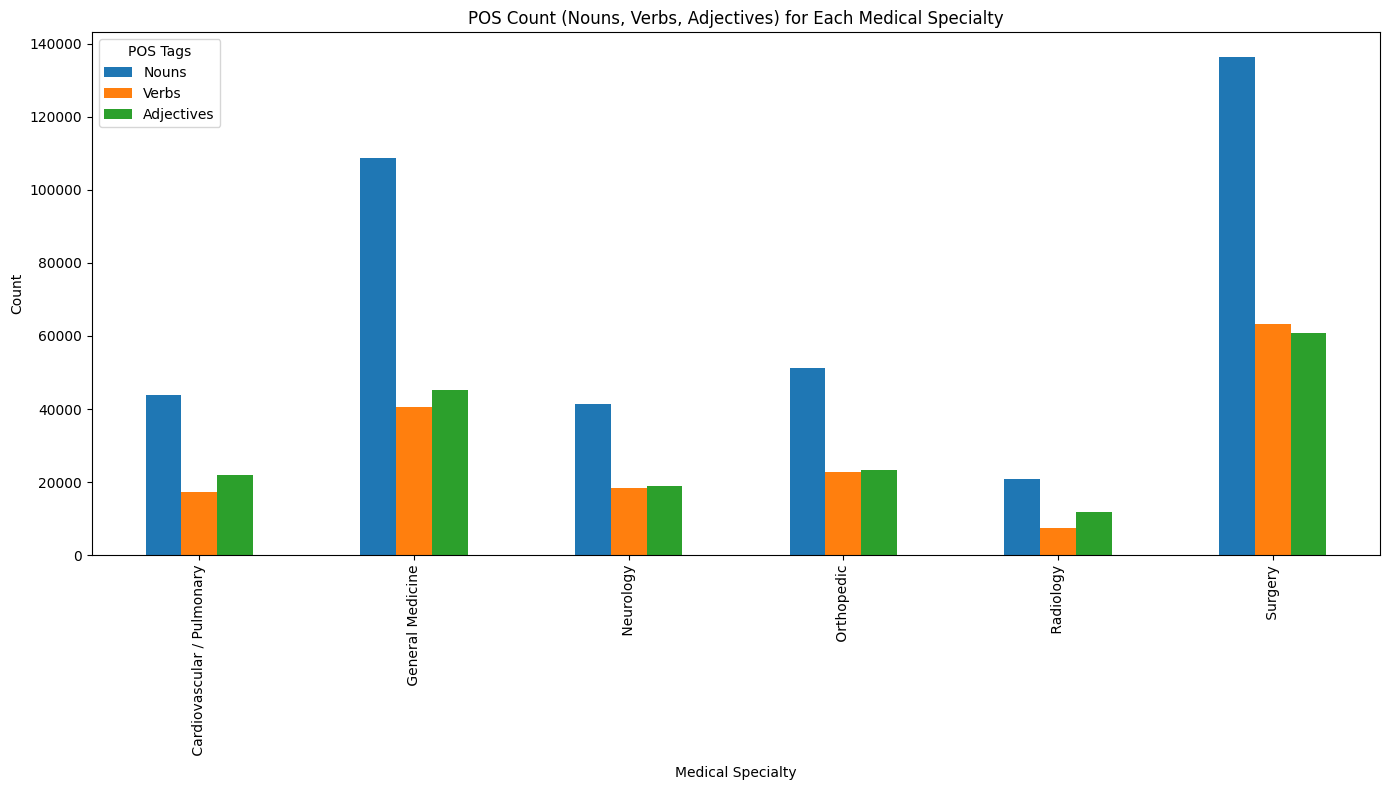

In [ ]:
pos_df.plot(kind='bar', figsize=(14, 8))
plt.title('POS Count (Nouns, Verbs, Adjectives) for Each Medical Specialty')
plt.xlabel('Medical Specialty')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='POS Tags')
plt.tight_layout()
plt.show()

# Data Pre Processing

In [ ]:
import re
import html
import textacy.preprocessing as tprep

def clean(text):
    cleaning_steps = {
        'punctuation_removed': False,
        'html_entities_removed': False,
        'tags_removed': False,
        'urls_removed': False,
        'brackets_removed': False,
        'specials_removed': False,
        'hyphens_removed': False,
        'whitespace_removed': False
    }

    # Normalization (no need to check here, as it's mostly formatting)
    text = tprep.normalize.hyphenated_words(text)
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)

    url_pattern = r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+(/[\w\d\-._~:/?#\[\]@!$&\'()*+,;=]*)?'
    text = re.sub(url_pattern, '', text)
    text_no_urls = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    if not re.search(r'https?://\S+', text_no_urls):  # Check if no URL remains
        cleaning_steps['urls_removed'] = True
    text = text_no_urls

    # Punctuation removal: Ensure no punctuation remains.
    text_without_punctuation = tprep.remove.punctuation(text)
    if not re.search(r'[^\w\s]', text_without_punctuation):  # check if no punctuation exists
        cleaning_steps['punctuation_removed'] = True
    text = text_without_punctuation

    # HTML entities removal: Check if HTML entities still exist.
    text_no_html_entities = html.unescape(text)
    if text_no_html_entities != text:
        cleaning_steps['html_entities_removed'] = True
    text = text_no_html_entities

    # HTML tag removal: Ensure no HTML tags remain.
    text_no_tags = re.sub(r'<[^<>]*>', ' ', text)
    if not re.search(r'<[^<>]*>', text_no_tags):  # Ensure no HTML tags are left
        cleaning_steps['tags_removed'] = True
    text = text_no_tags


    # Bracket removal: Ensure no text inside brackets exists.
    text_no_brackets = re.sub(r'\[[^\[\]]*\]', ' ', text)
    if not re.search(r'\[.*?\]', text_no_brackets):  # Check if no brackets remain
        cleaning_steps['brackets_removed'] = True
    text = text_no_brackets

    # Special characters removal: Check if standalone special characters are gone.
    text_no_specials = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    if not re.search(r'[&#<>{}\[\]+|\\:-]', text_no_specials):  # Ensure no special characters remain
        cleaning_steps['specials_removed'] = True
    text = text_no_specials

    # Hyphen removal: Ensure sequences of hyphens are removed.
    text_no_hyphens = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    if not re.search(r'[-=+]{2,}', text_no_hyphens):  # Ensure no hyphen sequences remain
        cleaning_steps['hyphens_removed'] = True
    text = text_no_hyphens

    # Whitespace cleanup: Ensure multiple spaces are removed and reduced to one.
    text_no_whitespace = re.sub(r'\s+', ' ', text)
    if text_no_whitespace != text:  # Check if whitespace was reduced
        cleaning_steps['whitespace_removed'] = True
    # Return cleaned text and the cleaning steps
    return text.strip(), cleaning_steps

In [ ]:
# Test cases
test_cases = [
    "Hello, world!",  # Test punctuation removal
    "Some text with <b>HTML tags</b> and &entities;",  # Test HTML handling
    "Check this link: https://example.com or [Click here](https://example.com)",  # Test URL removal
    "Remove [this text] in brackets",  # Test bracket removal
    "Special characters: &#{}<>[]",  # Test special character removal
    "Multiple --- hyphens or ====",  # Test hyphen sequence removal
    "   Extra    whitespace   here   ",  # Test whitespace cleanup
]

for i, test in enumerate(test_cases):
    cleaned_text, steps = clean(test)
    print(f"Test Case {i+1}:")
    print(f"Original: {test}")
    print(f"Cleaned: {cleaned_text}")
    print(f"Steps: {steps}")
    print("-" * 50)


Test Case 1:
Original: Hello, world!
Cleaned: Hello  world
Steps: {'punctuation_removed': True, 'html_entities_removed': False, 'tags_removed': True, 'urls_removed': True, 'brackets_removed': True, 'specials_removed': True, 'hyphens_removed': True, 'whitespace_removed': True}
--------------------------------------------------
Test Case 2:
Original: Some text with <b>HTML tags</b> and &entities;
Cleaned: Some text with  HTML tags  and  entities
Steps: {'punctuation_removed': False, 'html_entities_removed': False, 'tags_removed': True, 'urls_removed': True, 'brackets_removed': True, 'specials_removed': True, 'hyphens_removed': True, 'whitespace_removed': True}
--------------------------------------------------
Test Case 3:
Original: Check this link: https://example.com or [Click here](https://example.com)
Cleaned: Check this link   or Click here
Steps: {'punctuation_removed': True, 'html_entities_removed': False, 'tags_removed': True, 'urls_removed': True, 'brackets_removed': True, 'spec

In [ ]:
text = "Check this link: https://example.com or [Click here](https://example.com)"
url_pattern = r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+(/[\w\d\-._~:/?#\[\]@!$&\'()*+,;=]*)?'
# text = re.sub(url_pattern, '', text)
# text

In [ ]:
# Remove rows where the 'transcription' column has missing values
df.dropna(subset=['transcription'], inplace=True)


<ipython-input-15-1290971e10fd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['transcription'], inplace=True)


In [ ]:
# Clean the text in the 'transcription' column using the 'clean' function and update the column
df['transcription'] = df['transcription'].apply(lambda x: clean(x)[0])

<ipython-input-16-aa4e6316cdcb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transcription'] = df['transcription'].apply(lambda x: clean(x)[0])


In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Function to remove stopwords from text and return the filtered text
def remove_stopwords(text):
    words = text.split()  # Split the text into words
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words]  # Remove stop words
    return ' '.join(filtered_words)  # Rejoin the filtered words

# Function to remove numbers from text
def remove_numbers(text):
    return re.sub(r'\d+', '', text)
df['transcription_p'] = df['transcription'].apply(remove_stopwords)
df['transcription_p'] = df['transcription_p'].apply(remove_numbers)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-17-546a923d1bf0>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transcription_p'] = df['transcription'].apply(remove_stopwords)
<ipython-input-17-546a923d1bf0>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transcription_p'] = df['transcription_p'].apply(remove_numbers)


In [ ]:
# This is the code for extracting only medical terms from the text. This was not improving the results so we decided to not
# keep it in the final implementation but it will be useful for future applications

# !pip install scispacy
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bionlp13cg_md-0.5.1.tar.gz
# import scispacy
# import spacy
# nlp = spacy.load("en_ner_bionlp13cg_md")
# def medical_extraction( text):
#     words=[]
#     doc = nlp(text)
#     for ent in doc.ents:
#         words.append(ent.text)
#     return ' '.join(wordlist)
# df['medical_terms'] = df['transcription_p'].apply(medical_extraction)

# Vectorization

## TF - IDF

In [ ]:
# Perform TF-IDF vectorization, apply PCA for dimensionality reduction, and split the data into training and test sets
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

tfidf_vectorizer = TfidfVectorizer(max_features=1500)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['transcription_p'])

pca_tfidf = PCA(n_components=50, random_state=42)
pca_transformed = pca_tfidf.fit_transform(tfidf_matrix.toarray())
labels = df['medical_specialty'].astype('category').cat.codes
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(pca_transformed, labels, test_size=0.2, random_state=42)


In [ ]:
# Retrieve the feature names (words) corresponding to the TF-IDF matrix
tfidf_vectorizer.get_feature_names_out()

array(['abc', 'abcd', 'abdomen', ..., 'year', 'years', 'yesterday'],
      dtype=object)

In [ ]:
# Save the trained TF-IDF vectorizer to a file for future use
import pickle
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)

In [ ]:
# Save the trained PCA model to a file for future use
import pickle
with open('pca_model.pkl', 'wb') as file:
    pickle.dump(pca_tfidf, file)

## ClinicalBERT

In [ ]:
# Use ClinicalBERT to generate embeddings for the transcription data and prepare the dataset for training
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT").to(device)
model.save_pretrained("./models/Bio_ClinicalBERT")
tokenizer.save_pretrained("./models/Bio_ClinicalBERT")

# Function to generate ClinicalBERT embeddings for a batch of texts
def get_clinicalbert_embeddings(texts, tokenizer, model, device, batch_size=32, max_length=512):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size].tolist()
        tokens = tokenizer.batch_encode_plus(
            batch_texts,
            max_length=max_length,
            padding=True,
            truncation=True,
            return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            outputs = model(**tokens)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_embeddings.append(batch_embeddings)
    return np.vstack(all_embeddings)

# Get ClinicalBERT embeddings for the dataset
batch_size = 16  # Adjust batch size based on memory availability
embeddings = get_clinicalbert_embeddings(df['transcription_p'], tokenizer, model, device, batch_size=batch_size)

# Encode labels
labels = df['medical_specialty'].astype('category').cat.codes

# Split data into training and testing sets
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    embeddings, labels, test_size=0.2, random_state=42
)

print("ClinicalBERT embeddings and labels are ready!")


Using device: cpu


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

('./models/Bio_ClinicalBERT/tokenizer_config.json',
 './models/Bio_ClinicalBERT/special_tokens_map.json',
 './models/Bio_ClinicalBERT/vocab.txt',
 './models/Bio_ClinicalBERT/added_tokens.json',
 './models/Bio_ClinicalBERT/tokenizer.json')

In [ ]:
import os

# Example: Assuming you have a trained model named `trained_model`
model_save_path = "clinicalbert_model.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to clinicalbert_model.pth


## Word2Vec

In [ ]:
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import spacy
nlp = spacy.load("en_core_web_sm")

corpus = df['transcription_p'].tolist()
tokenized_corpus = [[token.text for token in nlp(sentence.lower())] for sentence in corpus]


# Word2Vec model
w2v_model = Word2Vec(
    sentences=tokenized_corpus,
    vector_size=300,  # Size of word embeddings
    window=20,         # Context window size
    min_count=2,      # Ignore words with frequency less than this
    workers=2,        # Number of CPU threads to use
    sg=1              # Skip-gram model; set to 0 for CBOW
)

# Saving the model
w2v_model.save("medical_word2vec.model")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np
from gensim.models import Word2Vec

# Training a Word2Vec model

# Generating sentence embeddings by averaging word embeddings
def get_sentence_embedding(sentence, w2v_model, embedding_dim=100):
    # Tokenize the sentence
    tokens = [token.text.lower() for token in nlp(sentence)]
    # Filter tokens that are present in the Word2Vec vocabulary
    tokens = [token for token in tokens if token in w2v_model.wv]
    # Return the average embedding; if no valid tokens, return a zero vector
    if tokens:
        return np.mean([w2v_model.wv[token] for token in tokens], axis=0)
    else:
        return np.zeros(embedding_dim)

# Creating embeddings
embedding_dim = w2v_model.vector_size  # Dimension of Word2Vec embeddings
sentence_embeddings = np.array([
    get_sentence_embedding(sentence, w2v_model, embedding_dim)
    for sentence in df['transcription_p']
])

# Train test split
labels = df['medical_specialty'].astype('category').cat.codes
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(
    sentence_embeddings, labels, test_size=0.2, random_state=42
)

print("Word2Vec embeddings and labels are ready for training!")


Word2Vec embeddings and labels are ready for training!


# Models

## Logistic Regression and TF IDF

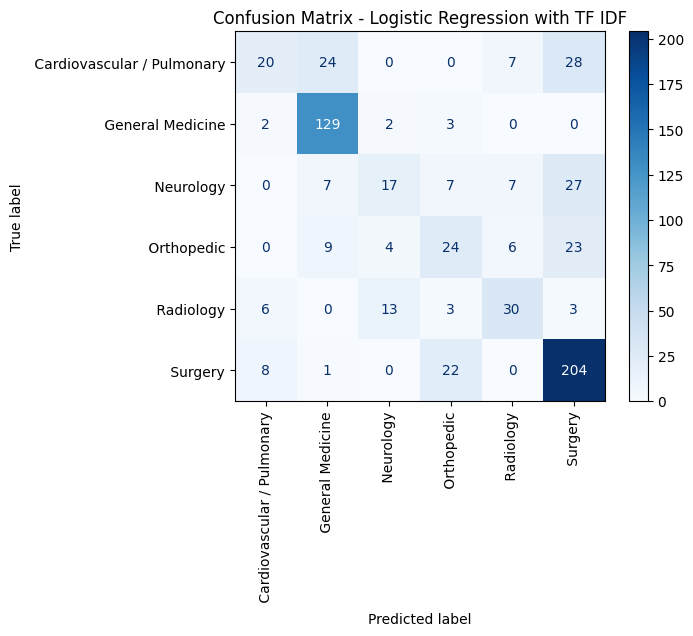

Classification Report:
                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.56      0.25      0.35        79
           General Medicine       0.76      0.95      0.84       136
                  Neurology       0.47      0.26      0.34        65
                 Orthopedic       0.41      0.36      0.38        66
                  Radiology       0.60      0.55      0.57        55
                    Surgery       0.72      0.87      0.78       235

                   accuracy                           0.67       636
                  macro avg       0.58      0.54      0.54       636
               weighted avg       0.64      0.67      0.64       636



In [ ]:
#Logisitc Regression TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Encode labels as categorical codes
labels = df['medical_specialty'].astype('category').cat.codes

from sklearn.linear_model import LogisticRegression

# Initialize the model with solver and multi_class options
lr_model_tfidf = LogisticRegression(
    random_state=42,
    max_iter=1000,
    solver='liblinear'

)
# Train the Logistic Regression model on the training data
lr_model_tfidf.fit(X_train_tfidf, y_train_tfidf)
# Make predictions using the test data
y_pred_tfidf = lr_model_tfidf.predict(X_test_tfidf)

# Compute confusion matrix to evaluate model performance
conf_matrix = confusion_matrix(y_test_tfidf, y_pred_tfidf)
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=df['medical_specialty'].astype('category').cat.categories)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix - Logistic Regression with TF IDF")
plt.show()
# Print classification report for model evaluation
print("Classification Report:")
print(classification_report(y_test_tfidf, y_pred_tfidf, target_names=df['medical_specialty'].astype('category').cat.categories))

In [ ]:
# Save the trained Logistic Regression model with TF-IDF features to a file
with open('lr_tfidf.pkl', 'wb') as model_file:
    pickle.dump(lr_model_tfidf, model_file)

## Logistic Regression with BERT

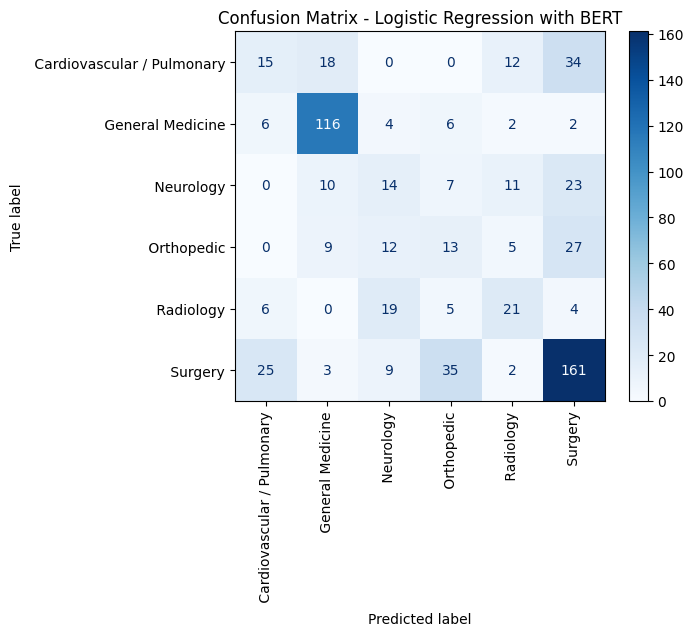

Classification Report:
                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.29      0.19      0.23        79
           General Medicine       0.74      0.85      0.79       136
                  Neurology       0.24      0.22      0.23        65
                 Orthopedic       0.20      0.20      0.20        66
                  Radiology       0.40      0.38      0.39        55
                    Surgery       0.64      0.69      0.66       235

                   accuracy                           0.53       636
                  macro avg       0.42      0.42      0.42       636
               weighted avg       0.51      0.53      0.52       636



In [ ]:
# Logistic Regression with BERT

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Initialize and train the Logistic Regression model on BERT embeddings
lr_model_bert = LogisticRegression(random_state=42, max_iter=1000)
lr_model_bert.fit(X_train_bert, y_train_bert)
# Make predictions using the test set
y_pred_bert = lr_model_bert.predict(X_test_bert)
# Compute confusion matrix to evaluate model performance
conf_matrix = confusion_matrix(y_test_bert, y_pred_bert)
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=df['medical_specialty'].astype('category').cat.categories)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix - Logistic Regression with BERT")
plt.show()
# Print classification report for model evaluation
print("Classification Report:")
print(classification_report(y_test_bert, y_pred_bert, target_names=df['medical_specialty'].astype('category').cat.categories))

In [ ]:
# Save the trained Logistic Regression model with BERT embeddings to a file
with open('lr_bert.pkl', 'wb') as model_file:
    pickle.dump(lr_model_bert, model_file)

## Logistic Regression with Word2Vec

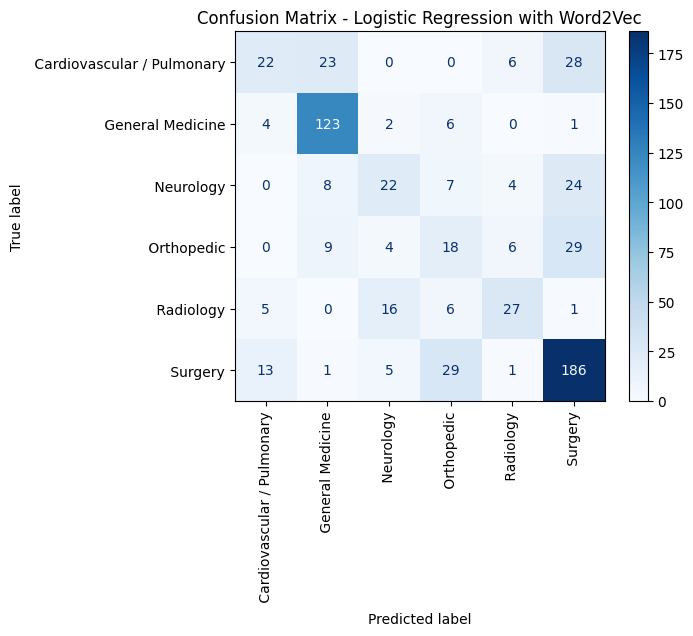

Classification Report:
                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.50      0.28      0.36        79
           General Medicine       0.75      0.90      0.82       136
                  Neurology       0.45      0.34      0.39        65
                 Orthopedic       0.27      0.27      0.27        66
                  Radiology       0.61      0.49      0.55        55
                    Surgery       0.69      0.79      0.74       235

                   accuracy                           0.63       636
                  macro avg       0.55      0.51      0.52       636
               weighted avg       0.61      0.63      0.61       636



In [ ]:
# Logistic Regression with W2Vec

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
# Initialize and train the Logistic Regression model on Word2Vec embeddings
lr_model_w2v = LogisticRegression(random_state=42, max_iter=1000)
lr_model_w2v.fit(X_train_w2v, y_train_w2v)
# Make predictions using the test set
y_pred_w2v = lr_model_w2v.predict(X_test_w2v)

# Compute confusion matrix to evaluate model performance
conf_matrix = confusion_matrix(y_test_w2v, y_pred_w2v)
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=df['medical_specialty'].astype('category').cat.categories)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix - Logistic Regression with Word2Vec")
plt.show()
# Print classification report for model evaluation
print("Classification Report:")
print(classification_report(y_test_w2v, y_pred_w2v, target_names=df['medical_specialty'].astype('category').cat.categories))

In [ ]:
# Save the trained Logistic Regression model with Word2Vec embeddings to a file
with open('lr_w2v.pkl', 'wb') as model_file:
    pickle.dump(lr_model_w2v, model_file)

## SVM with TF-IDF

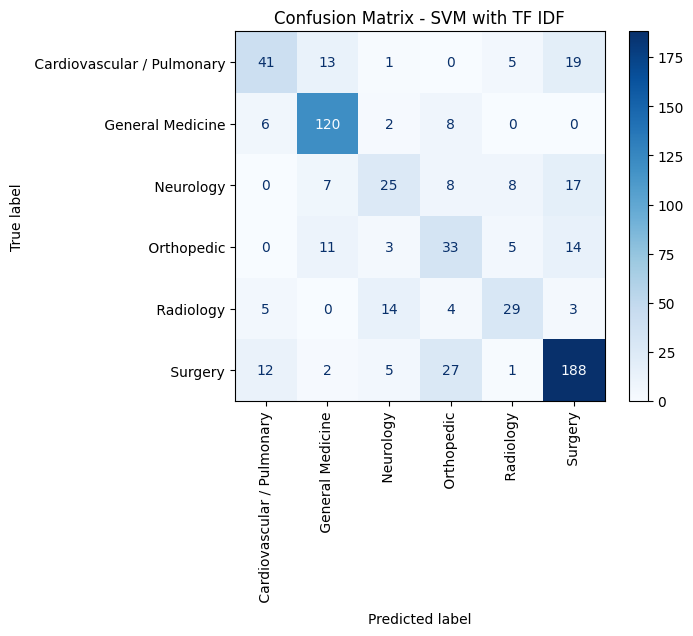

Classification Report:
                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.64      0.52      0.57        79
           General Medicine       0.78      0.88      0.83       136
                  Neurology       0.50      0.38      0.43        65
                 Orthopedic       0.41      0.50      0.45        66
                  Radiology       0.60      0.53      0.56        55
                    Surgery       0.78      0.80      0.79       235

                   accuracy                           0.69       636
                  macro avg       0.62      0.60      0.61       636
               weighted avg       0.68      0.69      0.68       636



In [ ]:
# Support Vector TFIDF

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# Encode labels as categorical codes
labels = df['medical_specialty'].astype('category').cat.codes
# Initialize and train the SVM model with sigmoid kernel
svm_model_tfidf = SVC(kernel='sigmoid')
svm_model_tfidf.fit(X_train_tfidf, y_train_tfidf)
# Make predictions using the test set
y_pred_tfidf = svm_model_tfidf.predict(X_test_tfidf)

# Compute confusion matrix to evaluate model performance
conf_matrix = confusion_matrix(y_test_tfidf, y_pred_tfidf)
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=df['medical_specialty'].astype('category').cat.categories)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix - SVM with TF IDF")
plt.show()
# Print classification report for model evaluation
print("Classification Report:")
print(classification_report(y_test_tfidf, y_pred_tfidf, target_names=df['medical_specialty'].astype('category').cat.categories))

In [ ]:
# Save the trained SVM model with TF-IDF features to a file
with open('svm_tfidf.pkl', 'wb') as model_file:
    pickle.dump(svm_model_tfidf, model_file)

## SVM with BERT

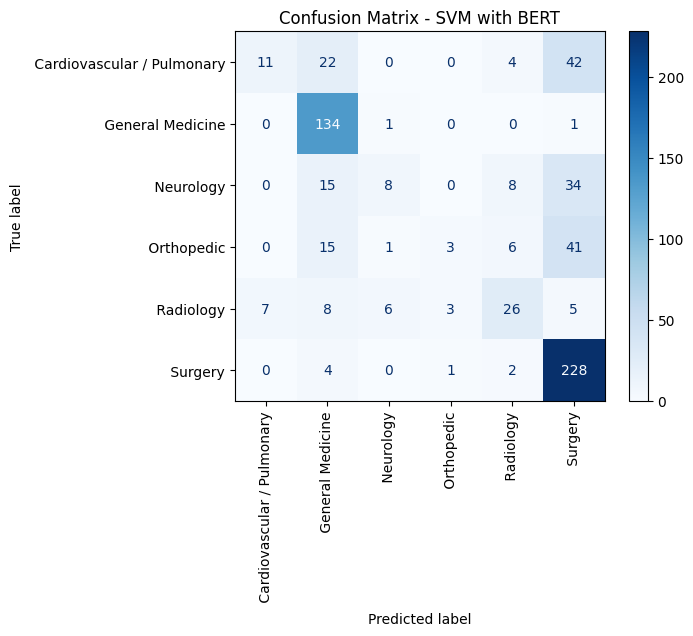

Classification Report:
                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.61      0.14      0.23        79
           General Medicine       0.68      0.99      0.80       136
                  Neurology       0.50      0.12      0.20        65
                 Orthopedic       0.43      0.05      0.08        66
                  Radiology       0.57      0.47      0.51        55
                    Surgery       0.65      0.97      0.78       235

                   accuracy                           0.64       636
                  macro avg       0.57      0.46      0.43       636
               weighted avg       0.61      0.64      0.56       636



In [ ]:
# Support Vector BERT

# Initialize and train the SVM model with sigmoid kernel on BERT embeddings
svm_model_bert = SVC(kernel='sigmoid')
svm_model_bert.fit(X_train_bert, y_train_bert)
# Make predictions using the test set
y_pred_bert = svm_model_bert.predict(X_test_bert)
# Compute confusion matrix to evaluate model performance
conf_matrix = confusion_matrix(y_test_bert, y_pred_bert)
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=df['medical_specialty'].astype('category').cat.categories)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix - SVM with BERT")
plt.show()
# Print classification report for model evaluation
print("Classification Report:")
print(classification_report(y_test_bert, y_pred_bert, target_names=df['medical_specialty'].astype('category').cat.categories))



In [ ]:
# Save the trained SVM model with BERT embeddings to a file
with open('svm_bert.pkl', 'wb') as model_file:
    pickle.dump(svm_model_bert, model_file)

## SVM with Word2Vec

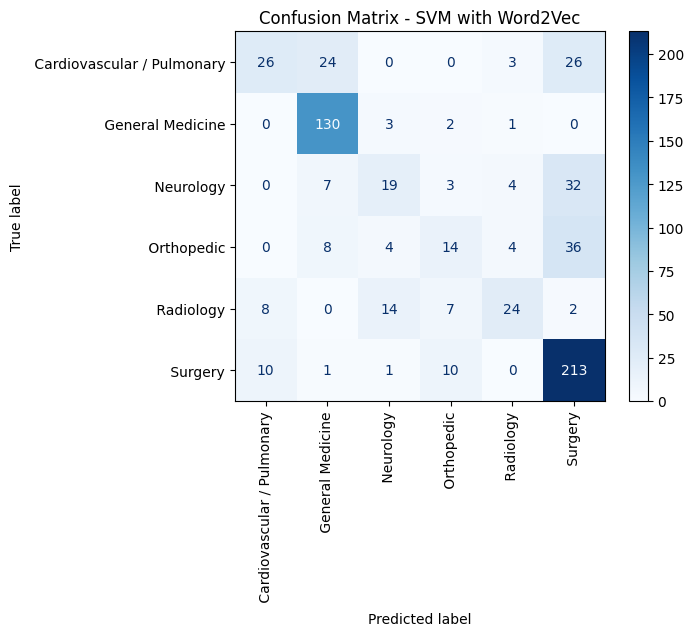

Classification Report:
                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.59      0.33      0.42        79
           General Medicine       0.76      0.96      0.85       136
                  Neurology       0.46      0.29      0.36        65
                 Orthopedic       0.39      0.21      0.27        66
                  Radiology       0.67      0.44      0.53        55
                    Surgery       0.69      0.91      0.78       235

                   accuracy                           0.67       636
                  macro avg       0.59      0.52      0.54       636
               weighted avg       0.64      0.67      0.63       636



In [ ]:
# Support Vector W2vec
from sklearn.svm import SVC
# Initialize and train the SVM model with sigmoid kernel and regularization parameter C=1
svm_model_w2v = SVC(kernel='sigmoid', C=1)
svm_model_w2v.fit(X_train_w2v, y_train_w2v)
# Make predictions using the test set
y_pred_w2v = svm_model_w2v.predict(X_test_w2v)

# Compute confusion matrix to evaluate model performance
conf_matrix = confusion_matrix(y_test_w2v, y_pred_w2v)
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=df['medical_specialty'].astype('category').cat.categories)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix - SVM with Word2Vec")
plt.show()
# Print classification report for model evaluation
print("Classification Report:")
print(classification_report(y_test_w2v, y_pred_w2v, target_names=df['medical_specialty'].astype('category').cat.categories))


In [ ]:
# Save the trained SVM model with Word2Vec embeddings to a file
with open('svm_w2v.pkl', 'wb') as model_file:
    pickle.dump(svm_model_w2v, model_file)

## Explainable SVM

Getting feature importances of different classes

In [ ]:
# Initialize the SVM model with a linear kernel and probability estimation enabled
svm_model_tfidf = SVC(kernel='linear', probability = True)
# Train the SVM model on the training data using TF-IDF features
svm_model_tfidf.fit(X_train_tfidf, y_train_tfidf)

SVC(kernel='linear', probability=True)

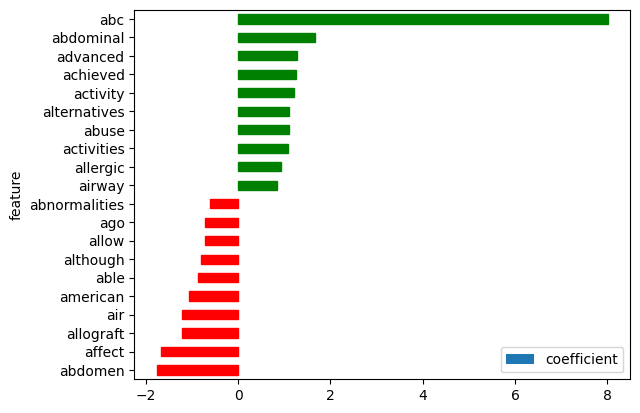

In [ ]:
# Get the coefficients (weights) of the trained SVM model for the TF-IDF features
coef = svm_model_tfidf.coef_[0]
# Sort the indices of the coefficients in ascending order
vocabulary_positions = coef.argsort()
# Get the vocabulary (words) corresponding to the TF-IDF features
vocabulary = tfidf_vectorizer.get_feature_names_out()

# Set the number of top words to display (positive and negative coefficients)
top_words = 10
# Get the indices of the top positive and negative coefficients
top_positive_coef = vocabulary_positions[-top_words:].tolist()
top_negative_coef = vocabulary_positions[:top_words].tolist()
# Create a DataFrame to display the words and their corresponding coefficients
coef_df = pd.DataFrame([[vocabulary[c], coef[c]] for c in top_positive_coef + top_negative_coef],
                          columns=["feature", "coefficient"]).sort_values("coefficient")
# Set the feature column as the index of the DataFrame
coef_df.set_index("feature")
10*['r']
ax = coef_df.set_index("feature").plot.barh()
# Define the colors for the bars: red for negative, green for positive coefficients
colors = ['red'] * 10 + ['green'] * 10
# Set the colors of the bars based on the coefficient value
for bar, color in zip(ax.patches, colors):
    bar.set_color(color)
# Save the plot as an SVG file
plt.savefig("coefficients-core-ui.svg")


In [ ]:
# Retrieve the coefficients (weights) for the second class from the SVM model
svm_model_tfidf.coef_[1]

array([ 0.59197079,  3.11049096,  5.89908082, -2.97750224, -0.01535994,
        2.10116268, -0.58318971, -0.56090085, -0.25836003,  1.65352566,
        0.79819428, -0.27869729, -0.62057506,  1.89311789, -0.33902776,
        1.03028083, -3.13681711,  0.11696293, -0.33512792, -0.00972263,
       -0.51009108, -0.55140186, -0.75613353, -1.05620118,  0.70679321,
       -0.14459306, -0.4116976 , -1.52855932,  0.65776742,  0.86322715,
        0.10844935, -0.45945465, -1.2897404 , -1.69261585, -1.15294899,
        0.92854869,  0.41226297,  0.54300456, -2.43850983,  0.00885053,
       -0.24760966, -0.05220181,  1.63813042, -0.18402196,  1.02004161,
       -0.80083993,  0.14632462,  0.30996858,  0.0833553 , -0.57274993])

## Random Forest with TF-IDF

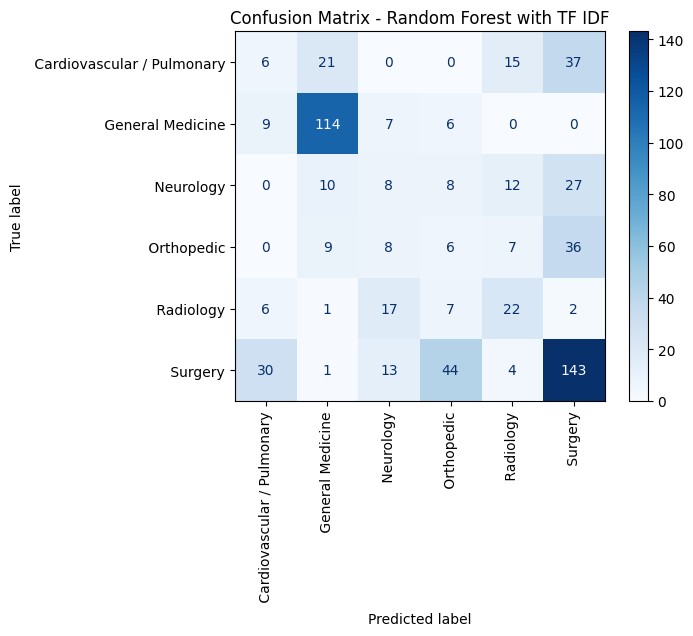

Classification Report:
                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.12      0.08      0.09        79
           General Medicine       0.73      0.84      0.78       136
                  Neurology       0.15      0.12      0.14        65
                 Orthopedic       0.08      0.09      0.09        66
                  Radiology       0.37      0.40      0.38        55
                    Surgery       0.58      0.61      0.60       235

                   accuracy                           0.47       636
                  macro avg       0.34      0.36      0.35       636
               weighted avg       0.44      0.47      0.45       636



In [ ]:
# Random Forest TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
# Encoding the medical specialties as numeric labels
labels = df['medical_specialty'].astype('category').cat.codes
# Initialize and train Random Forest model on TF-IDF features
rf_model_tfidf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf_model_tfidf.fit(X_train_tfidf, y_train_tfidf)
# Predicting the labels for the test set
y_pred_tfidf = rf_model_tfidf.predict(X_test_tfidf)

# Calculating and displaying the confusion matrix
conf_matrix = confusion_matrix(y_test_tfidf, y_pred_tfidf)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=df['medical_specialty'].astype('category').cat.categories)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix - Random Forest with TF IDF")
plt.show()
# Displaying the classification report
print("Classification Report:")
print(classification_report(y_test_tfidf, y_pred_tfidf, target_names=df['medical_specialty'].astype('category').cat.categories))

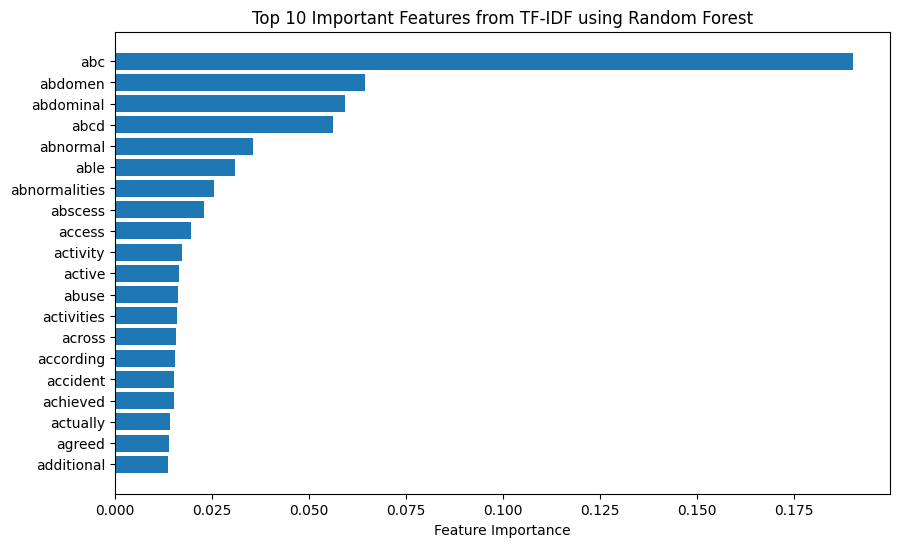

In [ ]:
# Extracting feature importances from the trained Random Forest model
feature_importances = rf_model_tfidf.feature_importances_
# Getting the feature names corresponding to the TF-IDF features
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
# Sorting the features by their importance in descending order
indices = np.argsort(feature_importances)[::-1]
# Defining the number of top features to display
top_n = 20
# Plotting the top n most important features
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), feature_importances[indices[:top_n]], align='center') # Bar plot of feature importances
plt.yticks(range(top_n), feature_names[indices[:top_n]]) # Displaying feature names on y-axis
plt.xlabel("Feature Importance") # Label for x-axis
plt.title("Top 10 Important Features from TF-IDF using Random Forest") # Title of the plot
plt.gca().invert_yaxis() # Inverting y-axis to display the most important feature at the top
plt.show() # Display the plot

In [ ]:
# Saving the trained Random Forest model with TF-IDF features to a file using pickle
with open('rf_tfidf.pkl', 'wb') as model_file:
    pickle.dump(rf_model_tfidf, model_file)

## Random Forest with BERT

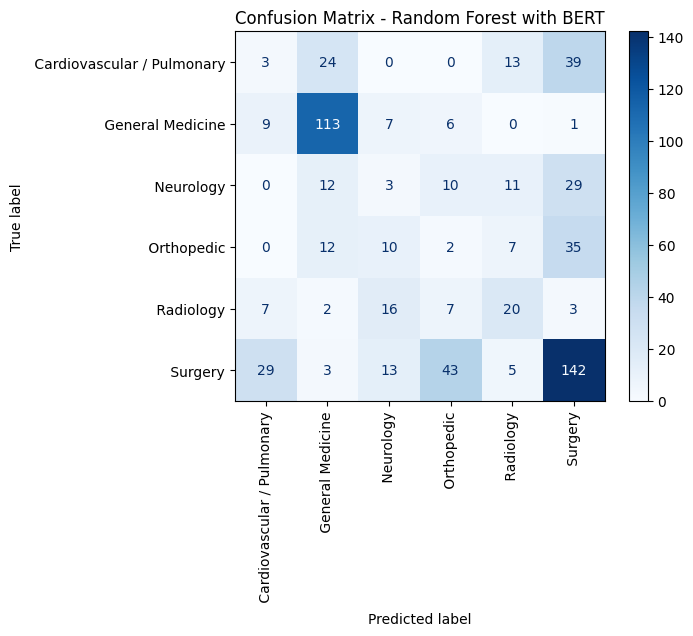

Classification Report:
                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.06      0.04      0.05        79
           General Medicine       0.68      0.83      0.75       136
                  Neurology       0.06      0.05      0.05        65
                 Orthopedic       0.03      0.03      0.03        66
                  Radiology       0.36      0.36      0.36        55
                    Surgery       0.57      0.60      0.59       235

                   accuracy                           0.44       636
                  macro avg       0.29      0.32      0.30       636
               weighted avg       0.40      0.44      0.42       636



In [ ]:
# Random Forest BERT
rf_model_bert = RandomForestClassifier(n_estimators=1000, random_state=42)
rf_model_bert.fit(X_train_bert, y_train_bert)

y_pred_bert = rf_model_bert.predict(X_test_bert)

# Display confusion matrix and classification report for model evaluation
conf_matrix = confusion_matrix(y_test_bert, y_pred_bert)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=df['medical_specialty'].astype('category').cat.categories)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix - Random Forest with BERT")
plt.show()
# Print the classification report to assess precision, recall, and F1-score
print("Classification Report:")
print(classification_report(y_test_bert, y_pred_bert, target_names=df['medical_specialty'].astype('category').cat.categories))

In [ ]:
# Save the trained Random Forest model (using BERT embeddings) to a file for future use
with open('rf_bert.pkl', 'wb') as model_file:
    pickle.dump(rf_model_bert, model_file)

## Random Forest with Word2Vec

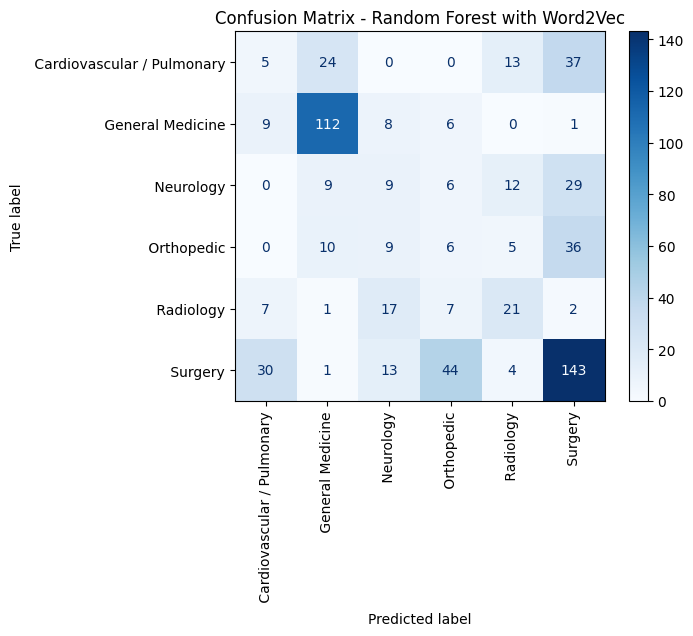

Classification Report:
                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.10      0.06      0.08        79
           General Medicine       0.71      0.82      0.76       136
                  Neurology       0.16      0.14      0.15        65
                 Orthopedic       0.09      0.09      0.09        66
                  Radiology       0.38      0.38      0.38        55
                    Surgery       0.58      0.61      0.59       235

                   accuracy                           0.47       636
                  macro avg       0.34      0.35      0.34       636
               weighted avg       0.44      0.47      0.45       636



In [ ]:
# Random Forest W2vec
from sklearn.ensemble import RandomForestClassifier
# Initializing and training the Random Forest model using Word2Vec features
rf_model_w2v = RandomForestClassifier(n_estimators=1000, random_state=42)
rf_model_w2v.fit(X_train_w2v, y_train_w2v)
# Making predictions with the trained model
y_pred_w2v = rf_model_w2v.predict(X_test_w2v)

# Generating and displaying confusion matrix
conf_matrix = confusion_matrix(y_test_w2v, y_pred_w2v)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=df['medical_specialty'].astype('category').cat.categories)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix - Random Forest with Word2Vec")
plt.show()
# Printing the classification report for evaluation metrics
print("Classification Report:")
print(classification_report(y_test_w2v, y_pred_w2v, target_names=df['medical_specialty'].astype('category').cat.categories))

In [ ]:
# Saving the trained Random Forest model using Word2Vec features to a file
with open('rf_w2v.pkl', 'wb') as model_file:
    pickle.dump(rf_model_w2v, model_file)

## RoBERTa

In [ ]:
# Install the 'transformers' library for working with pre-trained models and the 'datasets' library for easy dataset handling
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# Import the RobertaTokenizer from the Hugging Face Transformers library
from transformers import RobertaTokenizer
# Initialize the Roberta tokenizer using the pre-trained 'roberta-base' model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# Tokenize the 'transcription_p' column from the dataframe, applying padding, truncation, and setting the max length to 256 tokens, and return the tokenized data as PyTorch tensors
tokenized_data = tokenizer(list(df['transcription_p']), padding=True, truncation=True, max_length=256, return_tensors="pt")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
df['labels'] = label_encoder.fit_transform(df['medical_specialty'])

<ipython-input-50-6f26ce125ac0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['labels'] = label_encoder.fit_transform(df['medical_specialty'])


In [ ]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

# Split the tokenized inputs and labels together
X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    tokenized_data['input_ids'],
    tokenized_data['attention_mask'],
    df['labels'],
    test_size=0.2,
    random_state=42
)

# Convert to PyTorch tensors
X_train_ids = torch.tensor(X_train_ids, dtype=torch.long)
X_test_ids = torch.tensor(X_test_ids, dtype=torch.long)
X_train_mask = torch.tensor(X_train_mask, dtype=torch.long)
X_test_mask = torch.tensor(X_test_mask, dtype=torch.long)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

# Prepare TensorDataset and DataLoader
train_data = TensorDataset(X_train_ids, X_train_mask, y_train)
test_data = TensorDataset(X_test_ids, X_test_mask, y_test)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8)

print("DataLoader prepared successfully!")


DataLoader prepared successfully!


<ipython-input-51-29f5b5f2d082>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_ids = torch.tensor(X_train_ids, dtype=torch.long)
<ipython-input-51-29f5b5f2d082>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_ids = torch.tensor(X_test_ids, dtype=torch.long)
<ipython-input-51-29f5b5f2d082>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_mask = torch.tensor(X_train_mask, dtype=torch.long)
<ipython-input-51-29f5b5f2d082>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clon

In [ ]:
from transformers import AdamW
from transformers import RobertaForSequenceClassification
import torch
torch.cuda.empty_cache()
# Initialize the model with the correct number of labels
num_classes = len(df['labels'].unique())
model_rb = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_classes)

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move model to the selected device
model_rb.to(device)

# Optimizer
optimizer = AdamW(model_rb.parameters(), lr=1e-5)

# Training loop
model_rb.train()
for epoch in range(2):  # Number of epochs
    for batch in train_loader:
        # Move batch data to the same device as the model
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model_rb(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass
        loss.backward()
        optimizer.step()

        print(f"Epoch: {epoch}, Loss: {loss.item()}")


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch: 0, Loss: 1.7605477571487427
Epoch: 0, Loss: 1.8024747371673584
Epoch: 0, Loss: 1.7630250453948975
Epoch: 0, Loss: 1.755651593208313
Epoch: 0, Loss: 1.7758336067199707
Epoch: 0, Loss: 1.7971975803375244
Epoch: 0, Loss: 1.6229795217514038
Epoch: 0, Loss: 1.6968835592269897
Epoch: 0, Loss: 1.8026306629180908
Epoch: 0, Loss: 1.8792210817337036
Epoch: 0, Loss: 1.6695488691329956
Epoch: 0, Loss: 1.722304105758667
Epoch: 0, Loss: 1.8177034854888916
Epoch: 0, Loss: 1.7824275493621826
Epoch: 0, Loss: 1.6496760845184326
Epoch: 0, Loss: 1.822658658027649
Epoch: 0, Loss: 1.8269795179367065
Epoch: 0, Loss: 1.5575981140136719
Epoch: 0, Loss: 1.3971812725067139
Epoch: 0, Loss: 1.7886524200439453
Epoch: 0, Loss: 1.581049919128418
Epoch: 0, Loss: 1.805558681488037
Epoch: 0, Loss: 1.8902233839035034
Epoch: 0, Loss: 1.4845044612884521
Epoch: 0, Loss: 1.5477111339569092
Epoch: 0, Loss: 1.3132007122039795
Epoch: 0, Loss: 1.4552855491638184
Epoch: 0, Loss: 1.6134918928146362
Epoch: 0, Loss: 1.7419178

Accuracy: 0.6242

Classification Report:
                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.44      0.25      0.32        79
           General Medicine       0.79      0.85      0.82       136
                  Neurology       0.55      0.34      0.42        65
                 Orthopedic       0.37      0.89      0.52        66
                  Radiology       0.67      0.40      0.50        55
                    Surgery       0.75      0.68      0.71       235

                   accuracy                           0.62       636
                  macro avg       0.59      0.57      0.55       636
               weighted avg       0.65      0.62      0.62       636



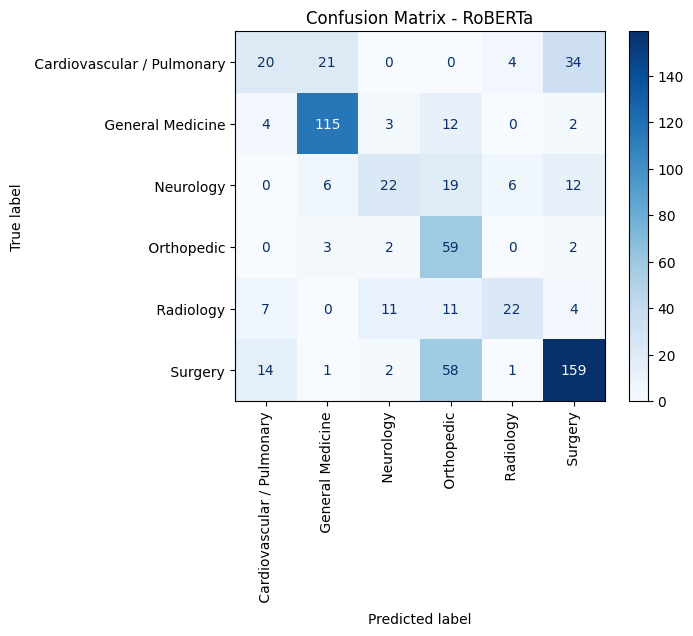

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Switch to evaluation mode
model_rb.eval()

all_preds = []
all_labels = []

# Evaluate on the test set
with torch.no_grad():
    for batch in test_loader:
        # Move batch data to the same device
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward pass
        outputs = model_rb(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Get predictions (class with the highest score)
        preds = torch.argmax(logits, dim=1)

        # Append predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

# # Convert label names to strings
# target_names = [str(label) for label in label_encoder.classes_]
target_names=df['medical_specialty'].astype('category').cat.categories.tolist()
# Compute classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=df['medical_specialty'].astype('category').cat.categories)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix - RoBERTa")
plt.show()


In [ ]:
import torch

# Save the model's state dictionary
torch.save(model_rb.state_dict(), "roberta.pth")
print("Model saved successfully as 'roberta.pth'.")


Model saved successfully as 'roberta.pth'.


## LSTM

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4417 - loss: 1.6003 - val_accuracy: 0.5770 - val_loss: 1.3084
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5796 - loss: 1.2447 - val_accuracy: 0.6258 - val_loss: 1.1498
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6270 - loss: 1.1049 - val_accuracy: 0.6431 - val_loss: 1.0803
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6403 - loss: 1.0370 - val_accuracy: 0.6478 - val_loss: 1.0344
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6568 - loss: 0.9868 - val_accuracy: 0.6541 - val_loss: 1.0004
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6408 - loss: 0.9780 - val_accuracy: 0.6431 - val_loss: 0.9775
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6586 - loss: 0.9314 - val_accuracy: 0.6478 - val_loss: 0.9511
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6397 - loss: 0.9241 - val_accuracy: 0.6541 - val_loss:

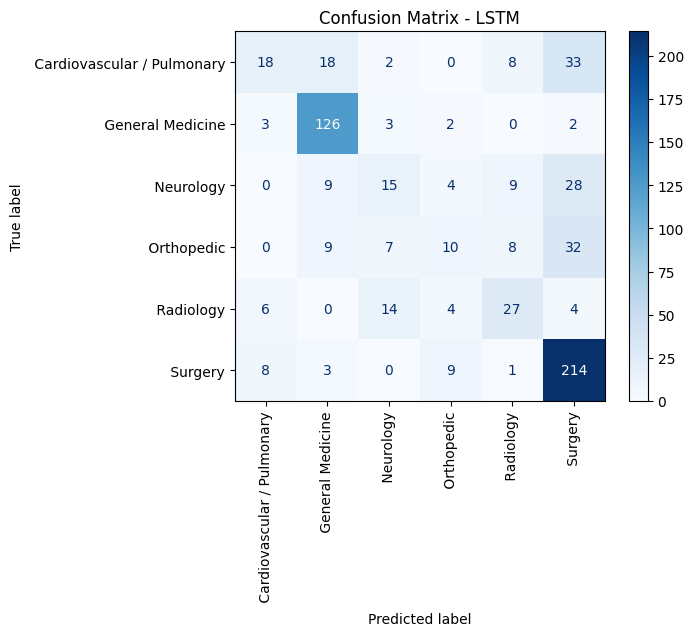

Classification Report:
                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.51      0.23      0.32        79
           General Medicine       0.76      0.93      0.84       136
                  Neurology       0.37      0.23      0.28        65
                 Orthopedic       0.34      0.15      0.21        66
                  Radiology       0.51      0.49      0.50        55
                    Surgery       0.68      0.91      0.78       235

                   accuracy                           0.64       636
                  macro avg       0.53      0.49      0.49       636
               weighted avg       0.60      0.64      0.60       636



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import numpy as np

# Convert labels to categorical (one-hot encoding)
num_classes = len(df['medical_specialty'].astype('category').cat.categories)
y_train_cat = to_categorical(y_train_bert, num_classes=num_classes)
y_test_cat = to_categorical(y_test_bert, num_classes=num_classes)

# Define LSTM Model
embedding_dim = X_train_bert.shape[1]  # Embedding size from ClinicalBERT
model = Sequential()
model.add(LSTM(256, input_shape=(1, embedding_dim), return_sequences=False))  # 128 hidden units
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax activation for multi-class classification

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Reshape data for LSTM: (samples, timesteps, features)
X_train_lstm = np.expand_dims(X_train_bert, axis=1)  # Add a "timesteps" dimension
X_test_lstm = np.expand_dims(X_test_bert, axis=1)

# Train the model
history = model.fit(X_train_lstm, y_train_cat, epochs=10, batch_size=32, validation_data=(X_test_lstm, y_test_cat))

# Predict on test data
y_pred_prob = model.predict(X_test_lstm)
y_pred_lstm = np.argmax(y_pred_prob, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_bert, y_pred_lstm)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=df['medical_specialty'].astype('category').cat.categories)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix - LSTM")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test_bert, y_pred_lstm, target_names=df['medical_specialty'].astype('category').cat.categories.tolist()))



In [ ]:
# Save the trained model
model_save_path = 'lstm_model.h5'  # Specify the path where you want to save the model
model.save(model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to lstm_model.h5
